# Plant Disease Detection

# Loading the dataset

In [ ]:
!wget https://www.dropbox.com/scl/fi/r6ukr09pabxphju9korr9/Tomato.zip?rlkey=ei9dsg4zj0exrpmcmkxt908uf&dl=0
!unzip Tomato.zip?rlkey=ei9dsg4zj0exrpmcmkxt908uf&dl=0

Streaming output truncated to the last 5000 lines.
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1263.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1264.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1265.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1266.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1267.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1268.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1269.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot127.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1270.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1271.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1272.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1273.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1274.jpg  
  inflating: Tomato/Tomato Target Spot/Tomato_Target_Spot1275.jpg 

### Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=200

### Import data into tensorflow dataset object

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Tomato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 37512 files belonging to 10 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Tomato Bacterial spot',
 'Tomato Early blight',
 'Tomato Late blight',
 'Tomato Leaf Mold',
 'Tomato Septoria leaf spot',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Target Spot',
 'Tomato Tomato mosaic virus',
 'Tomato healthy',
 'tomato canker']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 0 6 2 2 0 6 9 2 4 3 2 0 4 2 0 0 2 6 8 8 5 6 5 5 8 4 2 1 4 7 5]


### Visualize some of the images from our dataset

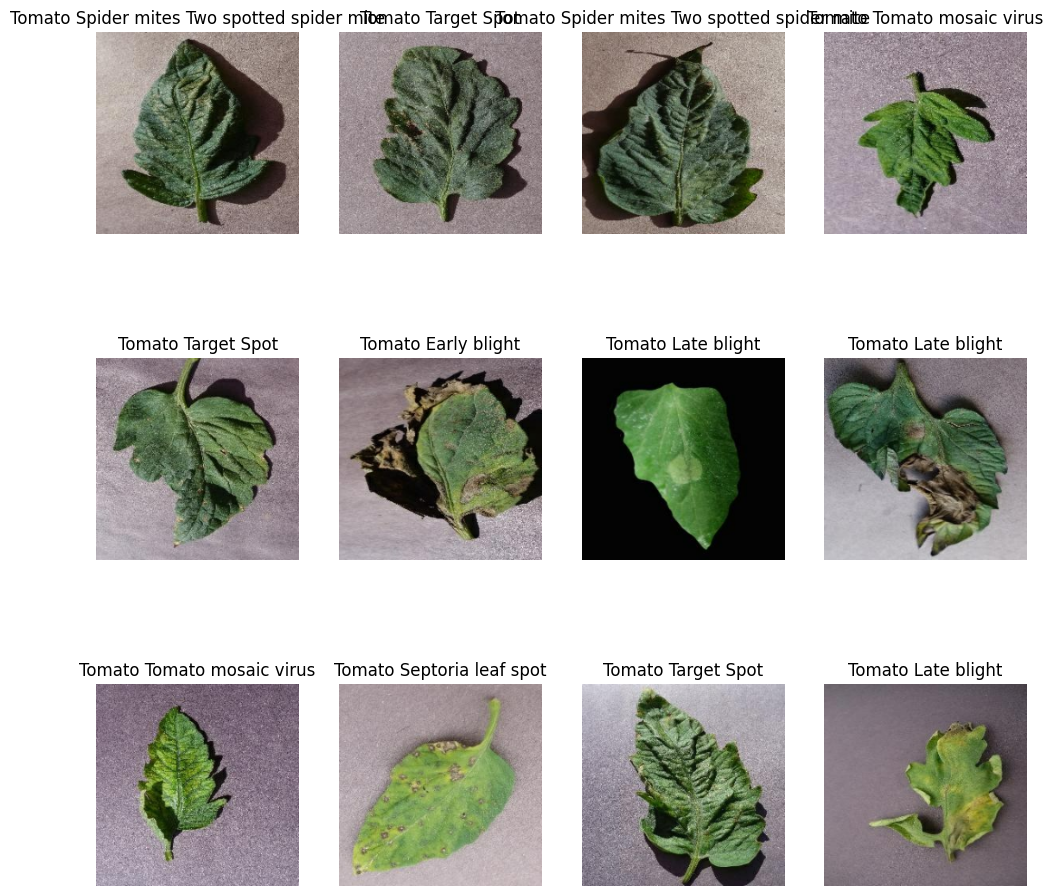

In [ ]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


### Spliting Dataset

Dataset is splitted into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

1173

In [ ]:
train_size = 0.8
len(dataset)*train_size

938.4000000000001

In [ ]:
train_ds = dataset.take(450)
len(train_ds)

450

In [ ]:
test_ds = dataset.skip(450)
len(test_ds)

1895

In [ ]:
val_size=0.1
len(dataset)*val_size

234.5

In [ ]:
val_ds = test_ds.take(50)
len(val_ds)

50

In [ ]:
test_ds = test_ds.skip(50)
test_ds = test_ds.take(50)
len(test_ds)

50

In [ ]:
#do not run
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
#do not run
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

938

In [ ]:
len(val_ds)

117

In [ ]:
len(test_ds)

118

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (16, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (16, 52, 52, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=20,         # Stop after 20 epochs with no improvement
    restore_best_weights=True  # Restore the best weights
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=200,
    callbacks=[early_stopping]  # Add the early stopping callback
)

Epoch 1/200
938/938 [==============================] - 36s 23ms/step - loss: 1.2687 - accuracy: 0.5394 - val_loss: 0.7154 - val_accuracy: 0.7489
Epoch 2/200
938/938 [==============================] - 13s 14ms/step - loss: 0.6277 - accuracy: 0.7781 - val_loss: 0.5377 - val_accuracy: 0.8192
Epoch 3/200
938/938 [==============================] - 13s 14ms/step - loss: 0.4509 - accuracy: 0.8407 - val_loss: 0.4360 - val_accuracy: 0.8518
Epoch 4/200
938/938 [==============================] - 13s 14ms/step - loss: 0.3357 - accuracy: 0.8838 - val_loss: 0.2505 - val_accuracy: 0.9172
Epoch 5/200
938/938 [==============================] - 13s 14ms/step - loss: 0.2622 - accuracy: 0.9088 - val_loss: 0.2251 - val_accuracy: 0.9215
Epoch 6/200
938/938 [==============================] - 13s 14ms/step - loss: 0.2297 - accuracy: 0.9201 - val_loss: 0.1747 - val_accuracy: 0.9383
Epoch 7/200
938/938 [==============================] - 13s 14ms/step - loss: 0.1819 - accuracy: 0.9360 - val_loss: 0.1185 - val_ac

In [ ]:
scores = model.evaluate(test_ds)

118/118 [==============================] - 7s 8ms/step - loss: 0.0237 - accuracy: 0.9939


In [ ]:
scores

[0.023652134463191032, 0.9939088821411133]

### Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 200, 'steps': 938}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

56

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.2686516046524048,
 0.6276732683181763,
 0.4509021043777466,
 0.33574002981185913,
 0.2621605098247528]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
print(acc)

[0.5394105315208435, 0.7780741453170776, 0.8406908512115479, 0.8838023543357849, 0.9088423848152161, 0.9201120138168335, 0.9359829425811768, 0.9417845010757446, 0.9541544318199158, 0.9541544318199158, 0.9585556387901306, 0.9692584872245789, 0.9660575985908508, 0.9724593162536621, 0.9748599529266357, 0.971992552280426, 0.9744265079498291, 0.9797946214675903, 0.9764270186424255, 0.9813616871833801, 0.9772605895996094, 0.9853960871696472, 0.9810616374015808, 0.9807615280151367, 0.9850626587867737, 0.9783942103385925, 0.9868298172950745, 0.9850626587867737, 0.9868631362915039, 0.9854294657707214, 0.9873966574668884, 0.9865630865097046, 0.985196053981781, 0.9900306463241577, 0.9886302947998047, 0.9862963557243347, 0.9852960705757141, 0.988196849822998, 0.9905641674995422, 0.9884969592094421, 0.9897305965423584, 0.9892638325691223, 0.9875633716583252, 0.9877634048461914, 0.9897972941398621, 0.9892304539680481, 0.9895638823509216, 0.9897639155387878, 0.9932315349578857, 0.9888303279876709, 0.

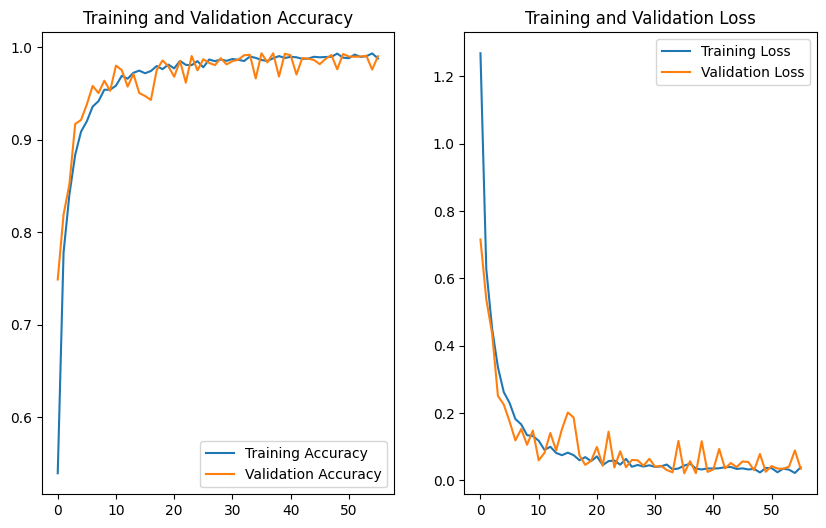

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(56), acc, label='Training Accuracy')
plt.plot(range(56), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(56), loss, label='Training Loss')
plt.plot(range(56), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

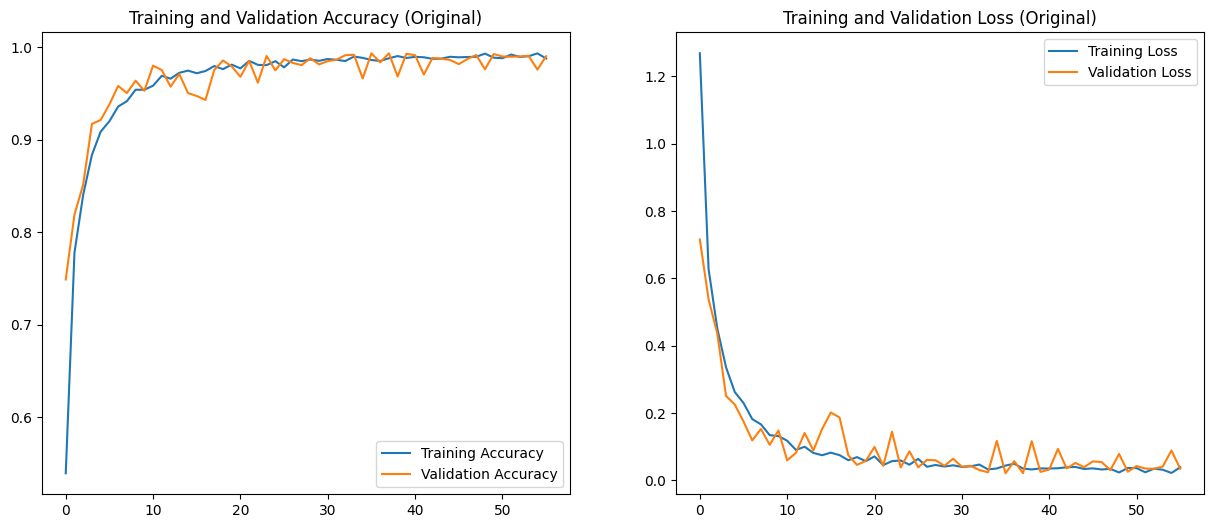

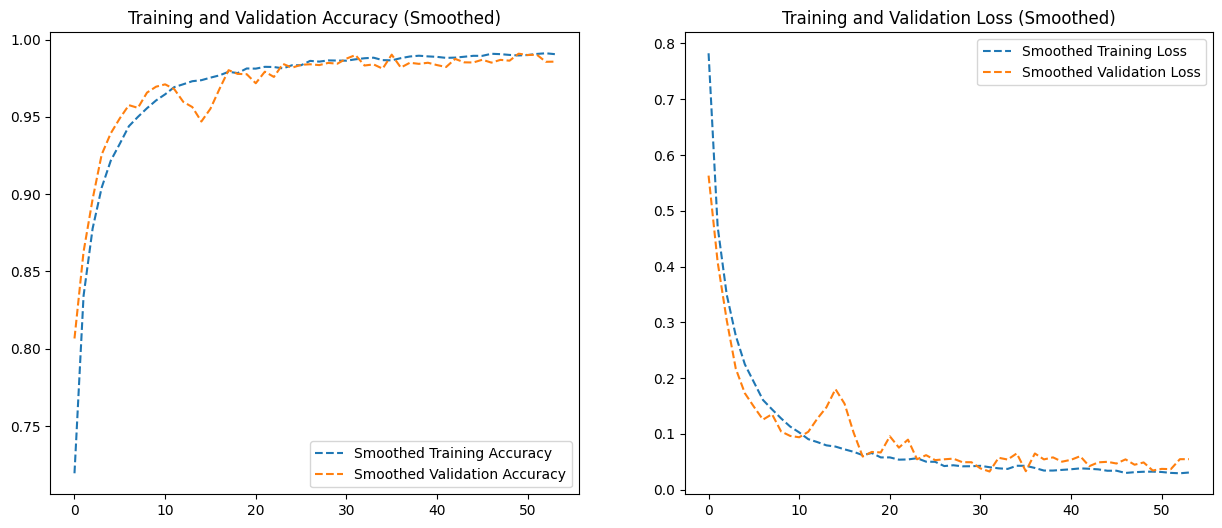

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# # Your data
# acc = # Your training accuracy data
# val_acc = # Your validation accuracy data
# loss = # Your training loss data
# val_loss = # Your validation loss data

# Function to calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Set window size for moving average
window_size = 3

# Create a figure with two subplots side by side
plt.figure(figsize=(15, 6))

# Subplot 1: Original Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(56), acc, label='Training Accuracy')
plt.plot(range(56), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Original)')

# Subplot 2: Original Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(56), loss, label='Training Loss')
plt.plot(range(56), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Original)')

# Create a figure with two subplots side by side for smoothed curves
plt.figure(figsize=(15, 6))

# Subplot 1: Smoothed Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(56 - window_size + 1), moving_average(acc, window_size), label='Smoothed Training Accuracy', linestyle='--')
plt.plot(range(56 - window_size + 1), moving_average(val_acc, window_size), label='Smoothed Validation Accuracy', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Smoothed)')

# Subplot 2: Smoothed Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(56 - window_size + 1), moving_average(loss, window_size), label='Smoothed Training Loss', linestyle='--')
plt.plot(range(56 - window_size + 1), moving_average(val_loss, window_size), label='Smoothed Validation Loss', linestyle='--')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Smoothed)')

# Display the plots
plt.show()


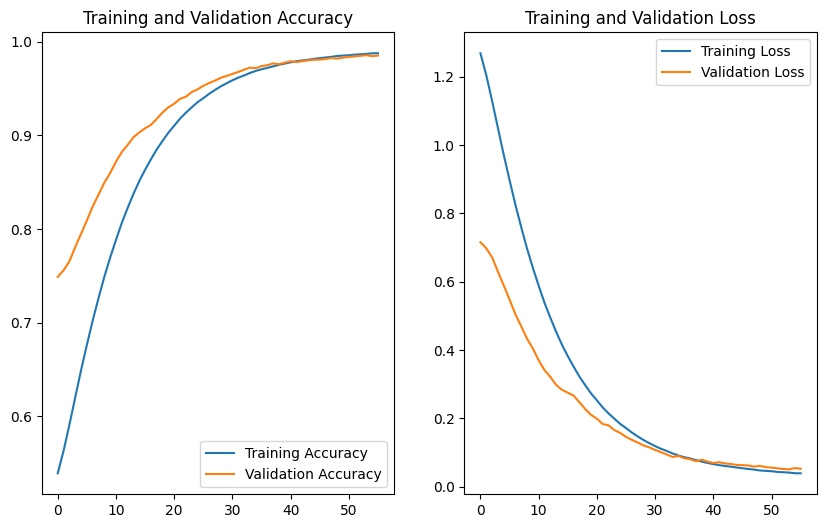

In [ ]:
import numpy as np

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.figure(figsize=(10, 6))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(56), smooth_curve(acc), label='Training Accuracy')
plt.plot(range(56), smooth_curve(val_acc), label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(56), smooth_curve(loss), label='Training Loss')
plt.plot(range(56), smooth_curve(val_loss), label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Run prediction on a sample image

first image to predict
actual label: Tomato Early blight
1/1 [==============================] - 0s 148ms/step
predicted label: Tomato Early blight


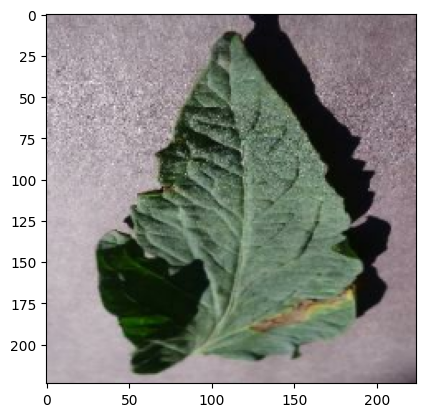

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 21ms/step


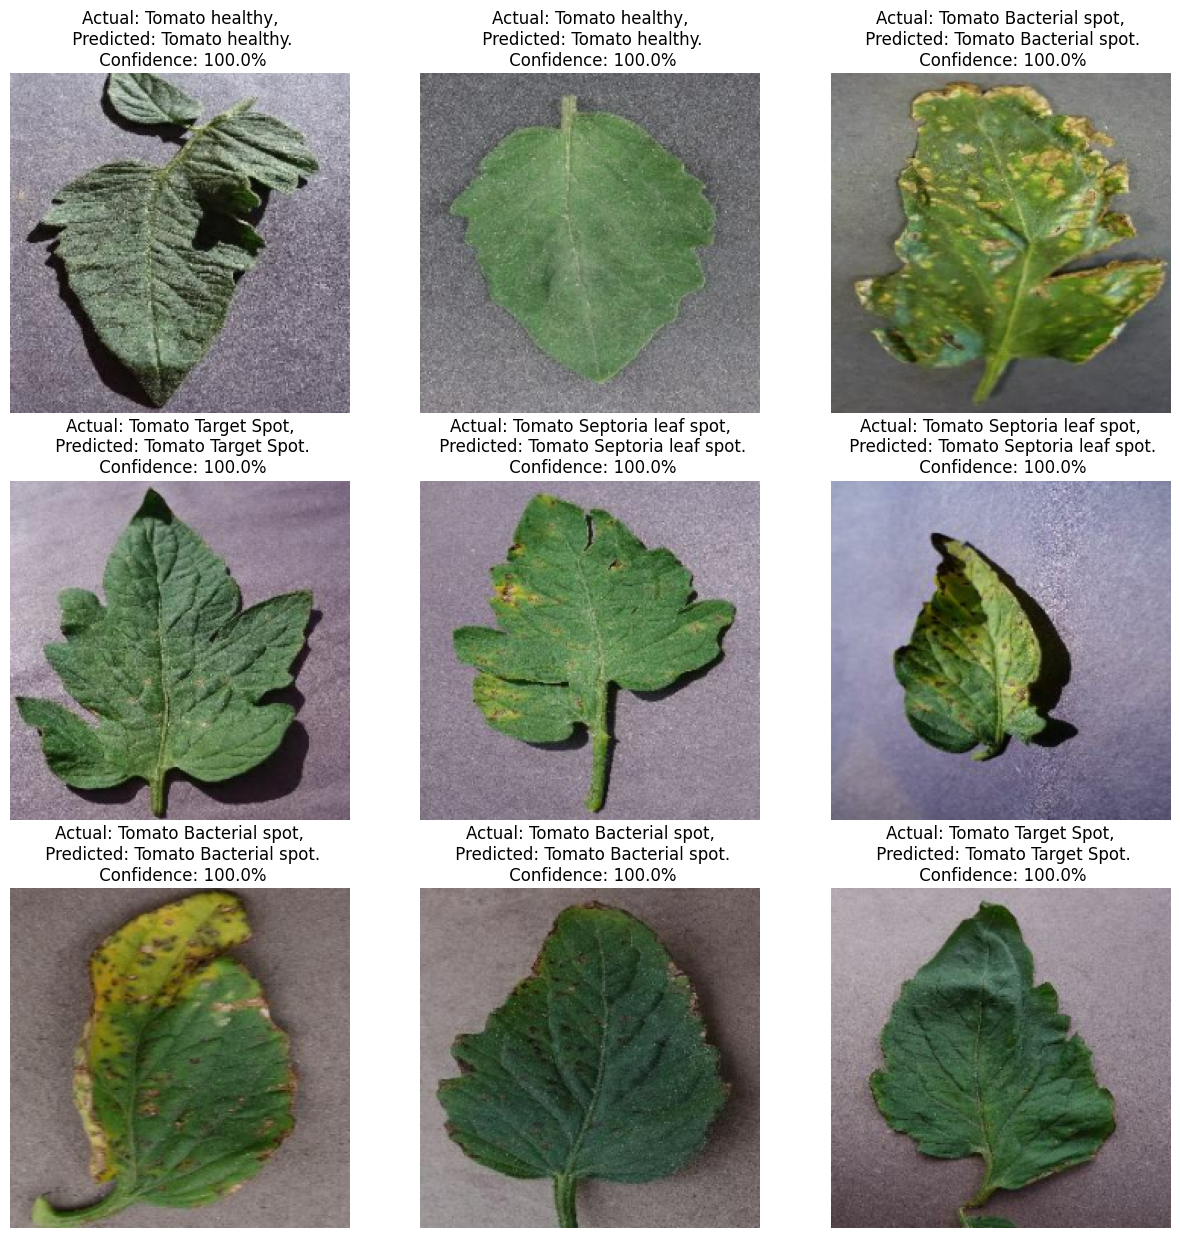

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
true_labels = []
predicted_labels = []

for images, labels in test_ds:  # Iterate through the entire test set
  for i in range(len(images)):
    predicted_class, _ = predict(model, images[i].numpy())
    true_labels.append(class_names[labels[i]])
    predicted_labels.append(predicted_class)

1/1 [==============================] - 0s 21ms/step


In [ ]:
len(true_labels)

3776

In [ ]:
len(predicted_labels)

3776

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels)

In [ ]:
print(cm)

[[630   1   0   0   0   0   0   0   0   0]
 [  1 287   1   0   1   0   0   0   0   0]
 [  0   3 558   0   1   1   0   0   1   0]
 [  0   0   0 276   0   0   0   0   0   0]
 [  0   2   1   0 581   0   0   0   0   0]
 [  0   0   0   0   0 507   3   0   0   0]
 [  0   4   0   0   1   0 411   0   0   0]
 [  0   0   0   0   0   1   0 117   0   0]
 [  0   0   0   0   0   0   1   0 378   0]
 [  0   0   0   0   0   0   0   0   0   8]]


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Given confusion matrix
conf_matrix = cm

# Calculate precision and recall using 'macro' average
precision = precision_score(conf_matrix.sum(axis=1), conf_matrix.diagonal(), average='macro')
recall = recall_score(conf_matrix.sum(axis=0), conf_matrix.diagonal(), average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


Precision: 0.1111
Recall: 0.1765


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


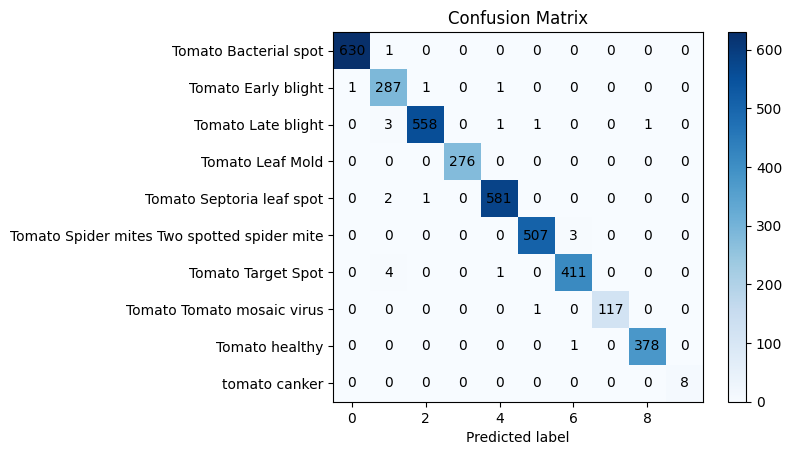

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'cm' is your confusion matrix
import numpy as np



plt.imshow(cm, cmap='Blues')

# Add text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

plt.colorbar()
plt.xlabel('Predicted label')
plt.yticks(np.arange(len(class_names)), class_names)  # Set y-axis ticks and labels
plt.title('Confusion Matrix')
plt.show()


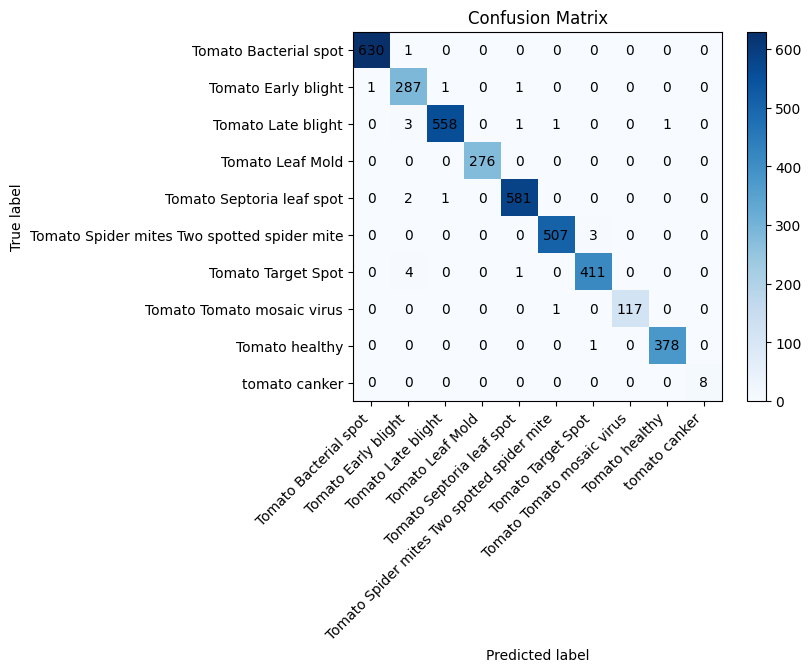

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ... your code for creating the confusion matrix 'cm' ...

plt.imshow(cm, cmap='Blues')

# Add text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

plt.colorbar()

# Set both x and y-axis labels using class_names:
plt.xlabel('Predicted label')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylabel('True label')
plt.yticks(np.arange(len(class_names)), class_names)

plt.title('Confusion Matrix')
plt.show()



In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1 = f1_score(true_labels, predicted_labels, average='weighted')

In [ ]:
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Weighted F1 score
print(f"Weighted F1 score: {f1:.4f}")

Weighted F1 score: 0.9939


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming 'y_true' is the true labels and 'y_pred' is the predicted labels
y_true = np.array(true_labels)
y_pred = np.array(predicted_labels)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate sensitivity/recall
true_positives = cm[1, 1]
false_negatives = cm[1, 0]
sensitivity = true_positives / (true_positives + false_negatives)

# Print sensitivity/recall
print(f"Sensitivity (Recall): {sensitivity:.2f}")


Sensitivity (Recall): 1.00


In [ ]:
print(y_pred)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


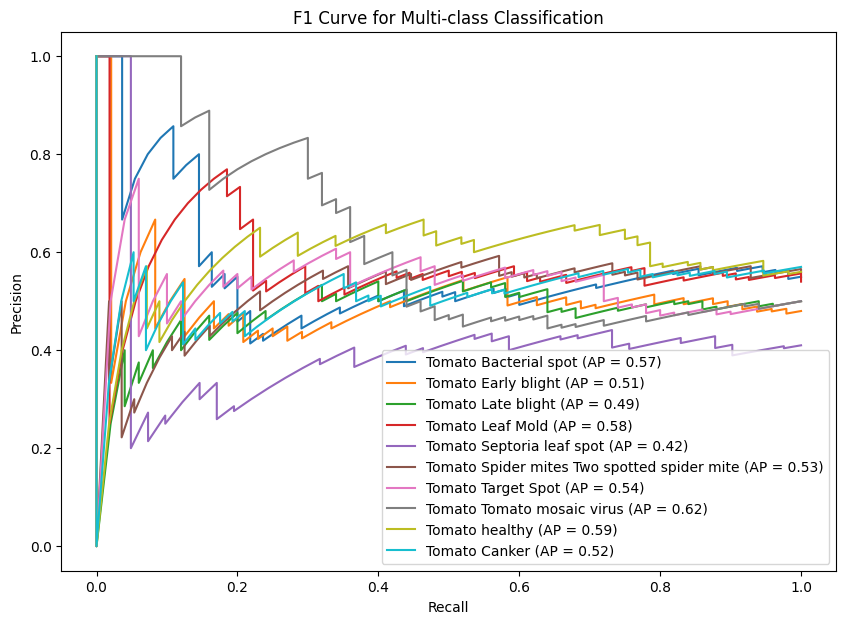

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Example: Replace these arrays with your actual predicted and true scores
# Make sure they have the shape (n_samples, n_classes)
# For simplicity, assuming binary classification for each class
y_pred = np.random.rand(100, 10)
y_true = np.random.randint(2, size=(100, 10))

# Define class names
class_names = ['Tomato Bacterial spot',
               'Tomato Early blight',
               'Tomato Late blight',
               'Tomato Leaf Mold',
               'Tomato Septoria leaf spot',
               'Tomato Spider mites Two spotted spider mite',
               'Tomato Target Spot',
               'Tomato Tomato mosaic virus',
               'Tomato healthy',
               'Tomato Canker']

# Compute precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(10):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

# Plot F1 curve for each class
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('F1 Curve for Multi-class Classification')
plt.legend()
plt.show()


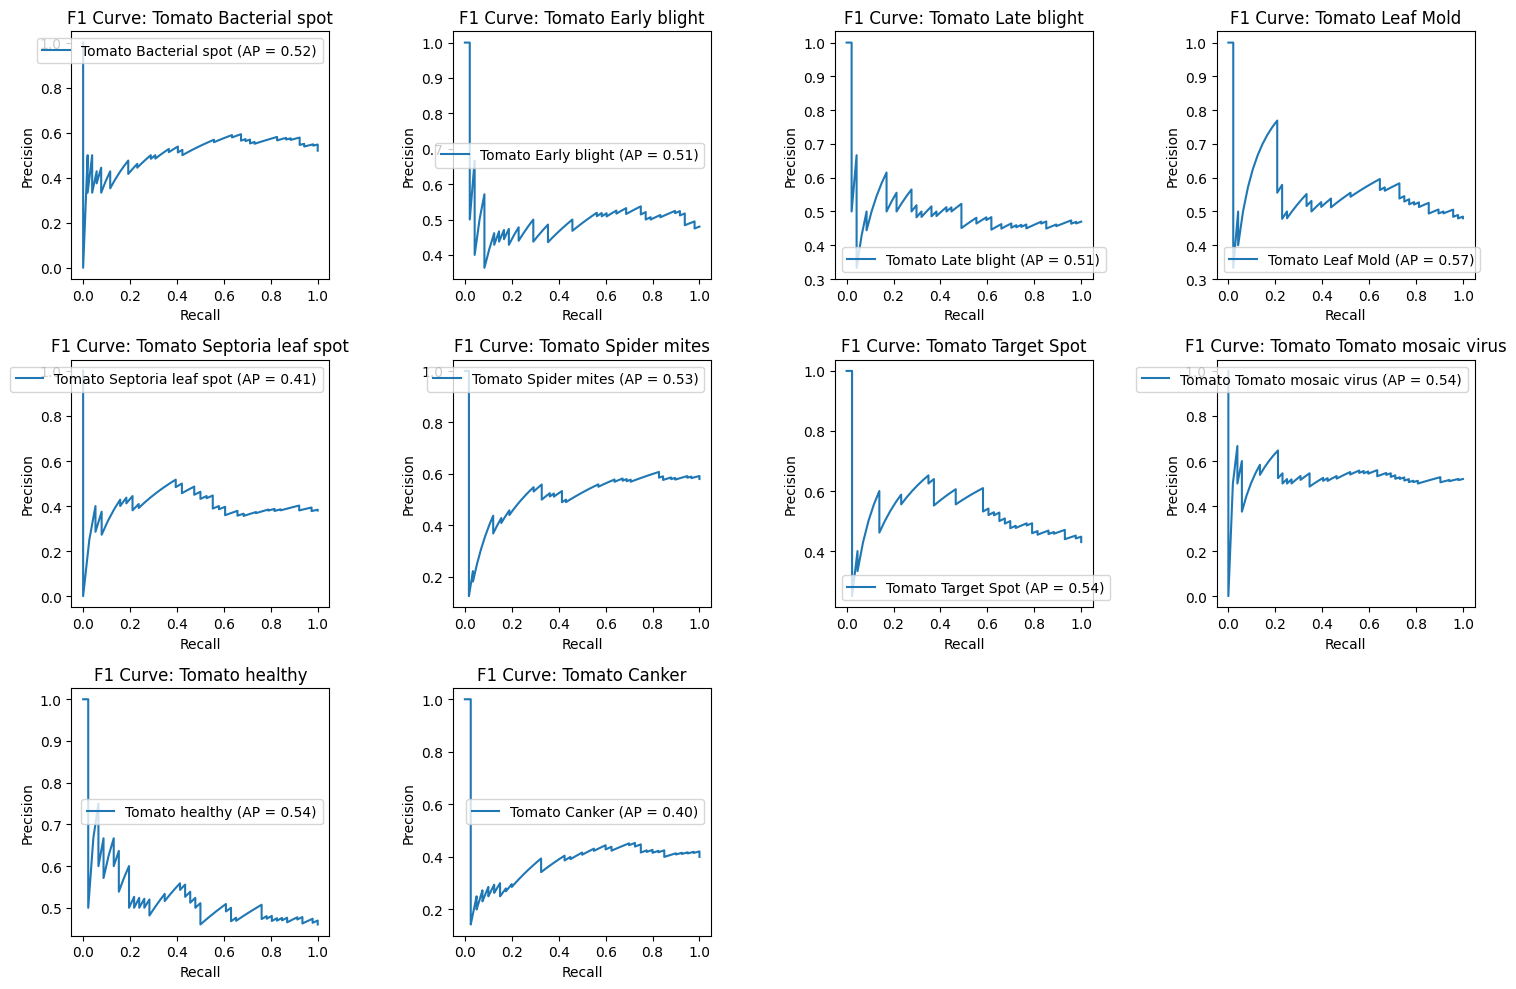

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Example: Replace these arrays with your actual predicted and true scores
# Make sure they have the shape (n_samples, n_classes)
# For simplicity, assuming binary classification for each class
y_pred = np.random.rand(100, 10)
y_true = np.random.randint(2, size=(100, 10))

# Define class names
class_names = ['Tomato Bacterial spot',
               'Tomato Early blight',
               'Tomato Late blight',
               'Tomato Leaf Mold',
               'Tomato Septoria leaf spot',
               'Tomato Spider mites',
               'Tomato Target Spot',
               'Tomato Tomato mosaic virus',
               'Tomato healthy',
               'Tomato Canker']

# Plot F1 curve for each class separately
plt.figure(figsize=(15, 10))

for i in range(10):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision = average_precision_score(y_true[:, i], y_pred[:, i])

    plt.subplot(3, 4, i + 1)
    plt.plot(recall, precision, label=f'{class_names[i]} (AP = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'F1 Curve: {class_names[i]}')
    plt.legend()

plt.tight_layout()
plt.show()


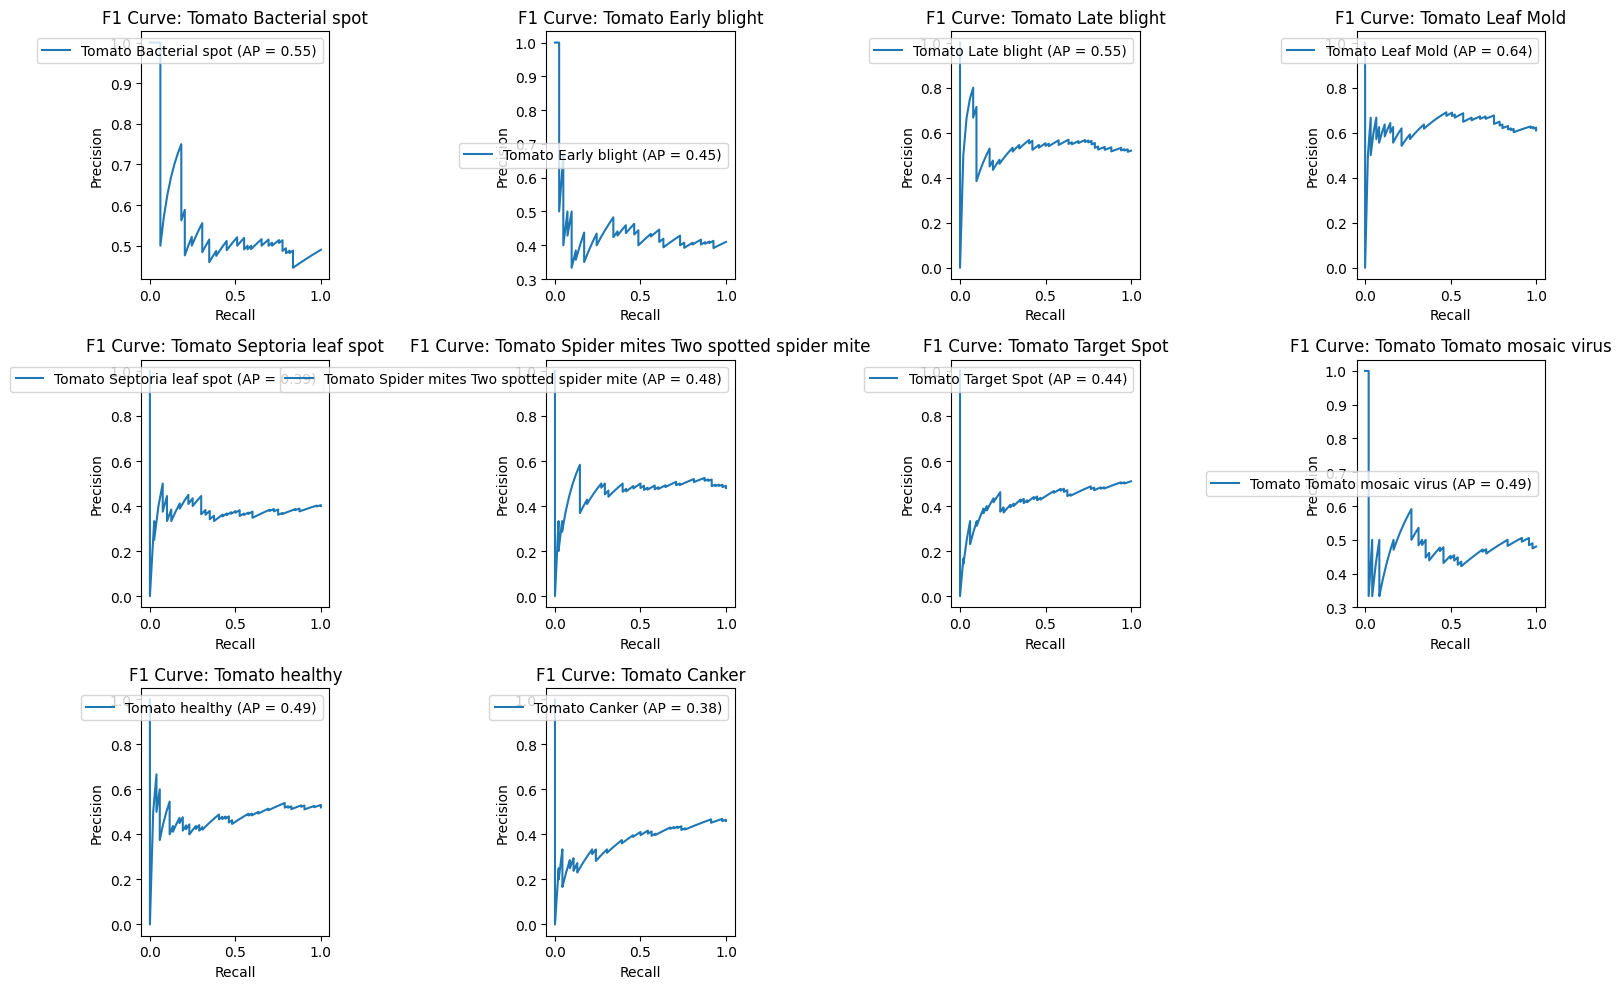

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Example: Replace these arrays with your actual predicted and true scores
# Make sure they have the shape (n_samples, n_classes)
# For simplicity, assuming binary classification for each class
y_pred = np.random.rand(100, 10)
y_true = np.random.randint(2, size=(100, 10))

# Define class names
class_names = ['Tomato Bacterial spot',
               'Tomato Early blight',
               'Tomato Late blight',
               'Tomato Leaf Mold',
               'Tomato Septoria leaf spot',
               'Tomato Spider mites',
               'Tomato Target Spot',
               'Tomato Tomato mosaic virus',
               'Tomato healthy',
               'Tomato Canker']

# Plot F1 curve for each class separately
plt.figure(figsize=(15, 10))

for i in range(10):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision = average_precision_score(y_true[:, i], y_pred[:, i])

    # Check if precision and recall arrays are not empty
    if precision.size != 0 and recall.size != 0:
        plt.subplot(3, 4, i + 1)
        plt.plot(recall, precision, label=f'{class_names[i]} (AP = {average_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'F1 Curve: {class_names[i]}')
        plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import os

# Specify the directory path
model_directory = "../models"

# Create the directory if it doesn't exist
os.makedirs(model_directory, exist_ok=True)

# Find the maximum model version or set it to 1 if the directory is empty
model_versions = [int(i) for i in os.listdir(model_directory)] + [0]
model_version = max(model_versions) + 1

# Save the model
model.save(os.path.join(model_directory, str(model_version)))


### Saving the Model
We append the model to the list of models as a new version

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
# Assuming model is your Keras model

# Save the model to the /content/ directory in Colab
model.save("/content/tomato(new).h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
